In [3]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install catboost

Note: you may need to restart the kernel to use updated packages.


# Определение стоимости автомобилей
Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore");
import lightgbm as lgb

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer
from lightgbm import LGBMRegressor
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from math import sqrt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostRegressor

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

In [2]:
data = pd.read_csv('C:/Users/ivche/Downloads/autos.csv')
display(data)
print(data.info())

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB
None


In [17]:
# Функция рассчета пропущенных значений
def missing_values_table(df):
        # Всего пропущенных
        mis_val = df.isnull().sum()
        
        # Пропущенных в процентах
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Таблица с результатами
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Переименование столбцов
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Пропущенные значения', 1 : '% от всех значений'})
        
        # Сортировка таблицы по пропущенным значениям
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% от всех значений', ascending=False).round(1)
        
        # Вывод дополнительной информации
        print ("Выбранный датасет содержит " + str(df.shape[1]) + " столбцов.\n"      
            "Всего " + str(mis_val_table_ren_columns.shape[0]) +
              " столбцов с пропущенными данными.")
        
        # Вывод датасета с пропущенными данными
        return mis_val_table_ren_columns

In [75]:
data = data.drop_duplicates()
missing_values_table(data)

Выбранный датасет содержит 16 столбцов.
Всего 5 столбцов с пропущенными данными.


,Пропущенные значения,% от всех значений
NotRepaired,71154,20.1
VehicleType,37490,10.6
FuelType,32895,9.3
Gearbox,19833,5.6
Model,19705,5.6


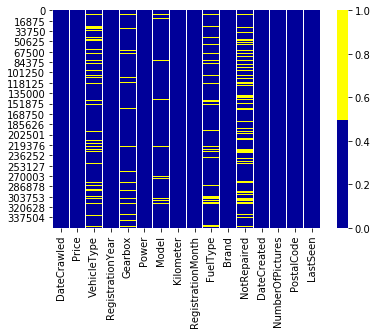

In [5]:
colours = ['#000099', '#ffff00'] 
sns.heatmap(data.isnull(), cmap=sns.color_palette(colours))

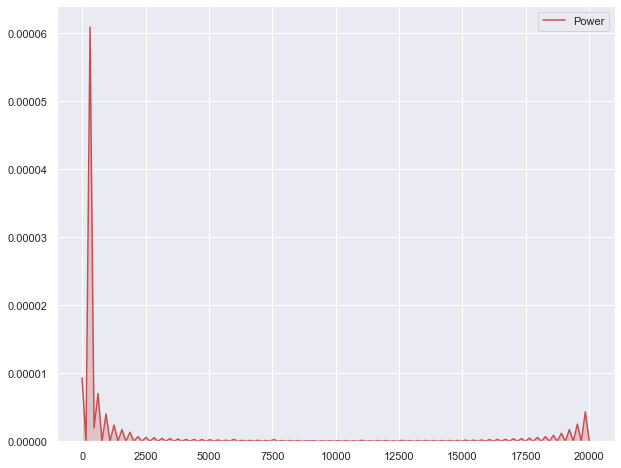

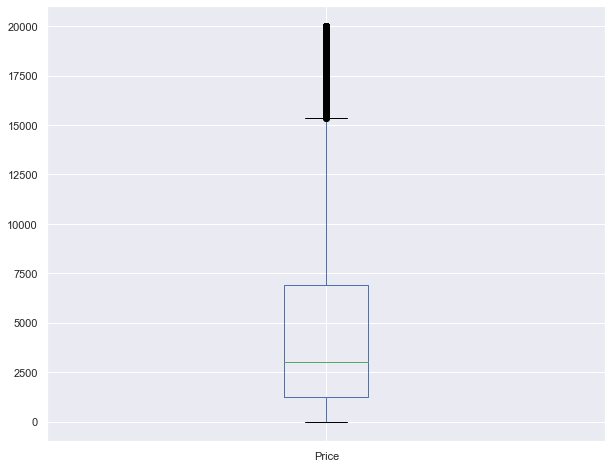

In [3]:
#заменю пропуски в вещественных данных
data['Model'] = data['Model'].fillna('unknown')
data['FuelType'] = data['FuelType'].fillna('unknown')
data['Gearbox'] = data['Gearbox'].fillna('unknown')
data['NotRepaired'] = data['NotRepaired'].fillna('unknown')
data['VehicleType'] = data.groupby('Model')['VehicleType'].transform(lambda x: x.fillna(x.mode()[0]))

sns.set(rc={'figure.figsize':(10,8)})
ax = sns.kdeplot(data['Power'] , shade=True, color='r', label='Power')
plt.show()
data = data.query('Power > 1').copy()
data.boxplot(column=['Price'])

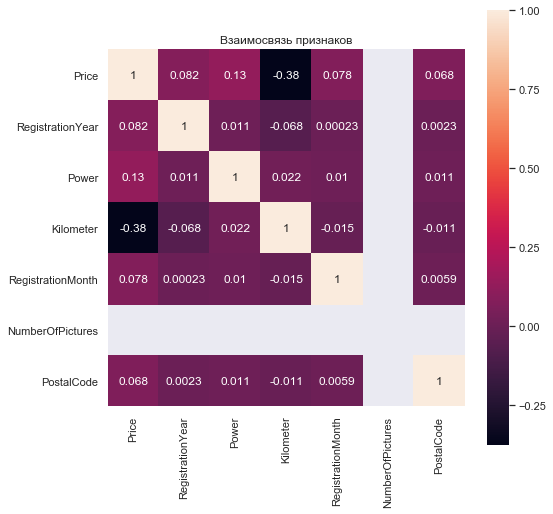

In [7]:
#Корреляция признаков
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(data.corr(), square=True, ax=ax, annot = True);
plt.title('Взаимосвязь признаков');

## Обучение моделей

### Определим признаки и целевой признак

In [4]:
features_train, features_test, target_train, target_test = train_test_split(
    data.drop(columns=['DateCrawled', 'Price', 'DateCreated', 'NumberOfPictures', 'LastSeen'], axis=1), data.Price, test_size=0.45, random_state=54321)
cat_features = ['VehicleType', 'Gearbox', 'Model',
                'FuelType', 'Brand','NotRepaired', 'PostalCode']
print('Размер обучающей выборки:', features_train.shape[0],'объектов')
print('Размер тестовой выборки:',features_test.shape[0],'объекта')

Размер обучающей выборки: 172760 объектов
Размер тестовой выборки: 141350 объекта


### Модель CatBoost

In [63]:
mse = make_scorer(mean_squared_error, greater_is_better=False)

In [8]:
CBR = CatBoostRegressor(loss_function="RMSE", random_seed=12345) 
hyper_params = {
    'learning_rate': [0.05, 0.2],
    "max_depth": [8],
    "n_estimators": [100]
}
gridCBR = GridSearchCV(CatBoostRegressor(cat_features=cat_features),
                       hyper_params, cv=3, n_jobs=-1,
                       scoring= mse)
gridCBR.fit(features_train, target_train, verbose=100) 
gridCBR.best_params_

0:	learn: 3992.7620142	total: 1.58s	remaining: 2m 36s
99:	learn: 1720.4955540	total: 1m 25s	remaining: 0us


{'learning_rate': 0.2, 'max_depth': 8, 'n_estimators': 100}

### LGBMRegressor

In [49]:
features_train[cat_features] = features_train[cat_features].astype('category')
features_test[cat_features] = features_test[cat_features].astype('category')  

In [10]:
hyper_params = {
    'metric': ['rmse'],
    'learning_rate': [0.1 ,0.05],
    'verbose': [100],
    "max_depth": [2,8],
    "n_estimators": [100],
    'min_samples_leaf': [3]
}

gridLGBM = GridSearchCV(LGBMRegressor(),hyper_params, cv=3, n_jobs=-1, scoring= mse)
gridLGBM.fit(features_train, target_train)
gridLGBM.best_params_

[LightGBM] [Warning] Unknown parameter: min_samples_leaf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: min_samples_leaf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.763033
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.154293
[LightGBM] [Debug] init for col-wise cost 0.425128 seconds, init for row-wise cost 0.224169 seconds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.713574 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 7716
[LightGBM] [Info] Number of data points in the train set: 204

{'learning_rate': 0.1,
 'max_depth': 8,
 'metric': 'rmse',
 'min_samples_leaf': 3,
 'n_estimators': 100,
 'verbose': 100}

In [5]:
features_train_ohe = pd.get_dummies(features_train, drop_first=True)

### Linear Regression with Scikit Learn’s SGDRegressor

In [65]:
param_dist = {'max_iter': [100, 10, 500]}

grid_linear = GridSearchCV(SGDRegressor(),param_dist, cv=3, n_jobs=-1)

grid_linear.fit(features_train_ohe, target_train)
grid_linear.best_params_

{'max_iter': 500}

<div class="alert alert-block alert-warning">
<b>Изменения:</b> Добавил Линейную Регрессию, но что-то резуьтат не очень

## Анализ моделей

In [45]:
#Датафрейм для сохранения результатов
metric = {'rmse':0, 'time_train':0, 'time_predict':0}
data_metric = pd.DataFrame.from_dict(metric, orient= 'index').rename(columns={0:'CBR'})

def metric_result(target_test, predictions, prefix):
    rmse = sqrt(mean_squared_error(target_test, predictions))
    time_train = result
    time_predict = result_pred
    data_metric[prefix] = 0
    data_metric.loc['rmse', prefix] = rmse
    data_metric.loc['time_train', prefix] = time_train
    data_metric.loc['time_predict', prefix] = time_predict
    
    return data_metric

In [46]:
modelCBR = CatBoostRegressor(loss_function="RMSE", learning_rate=0.2, max_depth=8, n_estimators=100, cat_features=cat_features)
result = %timeit -o modelCBR.fit(features_train, target_train) 
modelCBR.fit(features_train, target_train) 

0:	learn: 4467.0119889	total: 47.2ms	remaining: 4.67s
1:	learn: 4354.5621142	total: 76.8ms	remaining: 3.76s
2:	learn: 4249.5459295	total: 115ms	remaining: 3.73s
3:	learn: 4153.3173079	total: 145ms	remaining: 3.47s
4:	learn: 4061.6833582	total: 174ms	remaining: 3.3s
5:	learn: 3974.3746798	total: 201ms	remaining: 3.16s
6:	learn: 3892.7526404	total: 230ms	remaining: 3.06s
7:	learn: 3816.5043449	total: 263ms	remaining: 3.03s
8:	learn: 3744.6539812	total: 339ms	remaining: 3.42s
9:	learn: 3673.1416473	total: 378ms	remaining: 3.4s
10:	learn: 3609.6331964	total: 411ms	remaining: 3.32s
11:	learn: 3551.9643201	total: 442ms	remaining: 3.24s
12:	learn: 3494.5324018	total: 470ms	remaining: 3.15s
13:	learn: 3437.7815038	total: 502ms	remaining: 3.08s
14:	learn: 3383.8117708	total: 535ms	remaining: 3.03s
15:	learn: 3336.3081673	total: 562ms	remaining: 2.95s
16:	learn: 3289.1834626	total: 589ms	remaining: 2.88s
17:	learn: 3244.9530829	total: 616ms	remaining: 2.81s
18:	learn: 3199.6681785	total: 644ms	r

,CBR
rmse,2196.36
time_train,4.73 s ± 391 ms per loop (mean ± std. dev. of ...
time_predict,222 ms ± 10.9 ms per loop (mean ± std. dev. of...


In [47]:
result_pred = %timeit -o predictions = modelCBR.predict(features_test)
predictions = modelCBR.predict(features_test)
metric_result(target_test, predictions,'CBR')

190 ms ± 3.64 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


,CBR
rmse,2196.36
time_train,4.73 s ± 391 ms per loop (mean ± std. dev. of ...
time_predict,190 ms ± 3.64 ms per loop (mean ± std. dev. of...


In [51]:
modelLGBR = LGBMRegressor(learning_rate=0.1, max_depth=8, n_estimators=100)
result = %timeit -o modelLGBR.fit(features_train, target_train)
modelLGBR.fit(features_train, target_train, verbose=100) 

2.48 s ± 438 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=8,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [52]:
result_pred = %timeit -o predictionsLGBR = modelLGBR.predict(features_test)
predictionsLGBR = modelLGBR.predict(features_test)
metric_result(target_test, predictionsLGBR,'LGBR')

338 ms ± 24.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


,CBR,LGBR
rmse,2196.36,1741.55
time_train,4.73 s ± 391 ms per loop (mean ± std. dev. of ...,2.48 s ± 438 ms per loop (mean ± std. dev. of ...
time_predict,190 ms ± 3.64 ms per loop (mean ± std. dev. of...,338 ms ± 24.6 ms per loop (mean ± std. dev. of...


In [66]:
linreg_inst = SGDRegressor(max_iter=500)
result = %timeit -o linreg_inst.fit(features_train_ohe, target_train)
linreg_inst.fit(features_train_ohe, target_train)

1min 33s ± 1.81 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=500,
             n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=None,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)

In [82]:
features_test_ohe = pd.get_dummies(features_test, drop_first=True)
result_pred = %timeit -o prediction_linreg = linreg_inst.predict(features_test_ohe)
prediction_linreg = linreg_inst.predict(features_test_ohe)
metric_result(target_test, prediction_linreg,'LinReg')

245 ms ± 19.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


,CBR,LGBR,LinReg
rmse,2196.36,1741.55,9.3079e+17
time_train,4.73 s ± 391 ms per loop (mean ± std. dev. of ...,2.48 s ± 438 ms per loop (mean ± std. dev. of ...,1min 33s ± 1.81 s per loop (mean ± std. dev. o...
time_predict,190 ms ± 3.64 ms per loop (mean ± std. dev. of...,338 ms ± 24.6 ms per loop (mean ± std. dev. of...,245 ms ± 19.6 ms per loop (mean ± std. dev. of...


<div class="alert alert-block alert-warning">
<b>Изменения:</b> Удалось достичь rmse 700 на Catboost но с теми параметрами зависала тетрадка. Но вцелом этот регрессор удобнее и по скорости и по качеству. Правда LGBM быстрее на обучении.
</div>